In [1]:
import pandas as pd
import numpy as np
import librosa
import IPython.display as ipd
from glob import glob

In [ ]:
train_data = pd.read_csv(r"Train.csv")

In [3]:
train_data.head(1)

,New,Classification
0,1725_.wav,Major


In [4]:
train_data = train_data.rename(columns={"New" : "Audio"})
tdf_copy = train_data.copy()

In [5]:
train_data['label'] = train_data['Classification'].apply(lambda x:1 if x=='Major' else 0)
train_data.drop('Classification', axis=1, inplace=True)

In [ ]:
train_data

,Audio,label
0,1725_.wav,1
1,1659_.wav,0
2,2029_.wav,1
3,2093_.wav,0
4,1661_.wav,1
...,...,...
673,1567_.wav,1
674,2265_.wav,0
675,1799_.wav,0
676,1780_.wav,0


In [9]:
train_data["label"].value_counts(normalize=True)*100

label
1    56.932153
0    43.067847
Name: proportion, dtype: float64

In [ ]:
audio_dir = r"Audio_Files"

In [10]:
def load_and_extract_features(audio_file):
    y, sr = librosa.load(audio_dir + "/" + audio_file)
    pd.Series(y).plot()

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    return mfcc

In [11]:
def load_with_labels(data):
    X = []
    y = []
    for _, row in data.iterrows():
        audio_file = row["Audio"]
        label = row["label"]
        features = load_and_extract_features(audio_file)
        X.append(features)
        y.append(label)
    return X, y

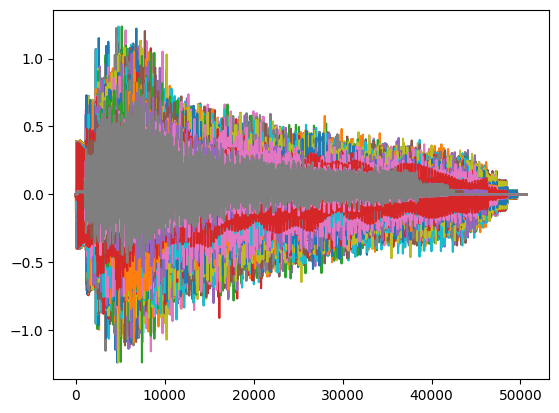

In [14]:
X_train, y_train = load_with_labels(train_data)

In [15]:
audio_files = glob(audio_dir + "*/*.wav")

In [62]:
aud = ipd.Audio(audio_files[88])
aud

<Axes: >

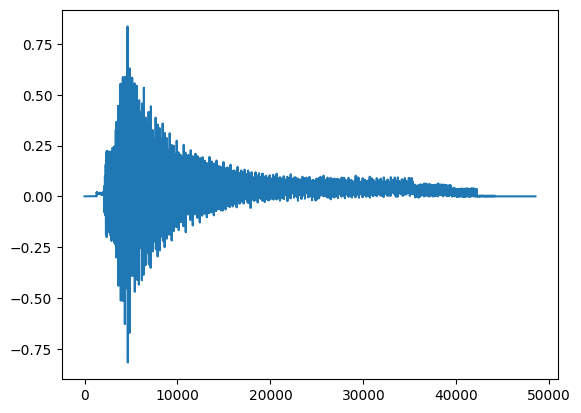

In [63]:
y, sr = librosa.load(audio_files[np.random.randint(0, 500)])
pd.Series(y).plot()

### Spectogram

In [64]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref = np.max)


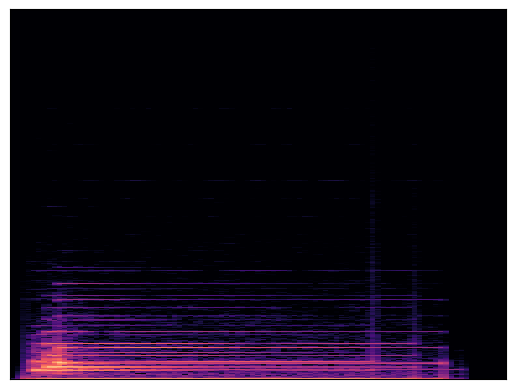

In [65]:
img = librosa.display.specshow(S_db)

In [66]:
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db_mel = librosa.amplitude_to_db(S, ref=np.max)

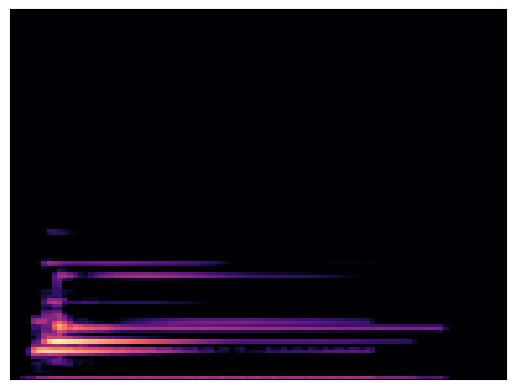

In [67]:
img = librosa.display.specshow(S_db_mel)

In [68]:
y[10]

np.float32(-1.2089731e-07)

In [69]:
print(D.shape)
print(S_db_mel.shape)

(1025, 95)
(128, 95)


In [70]:
y

array([ 1.6007107e-09,  6.9849193e-09, -1.6676495e-08, ...,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00], dtype=float32)

In [71]:
train_data

,Audio,label
0,1725_.wav,1
1,1659_.wav,0
2,2029_.wav,1
3,2093_.wav,0
4,1661_.wav,1
...,...,...
673,1567_.wav,1
674,2265_.wav,0
675,1799_.wav,0
676,1780_.wav,0


In [ ]:
audio_dir = r"Audio_Files"
import pandas as pd
import librosa
import numpy as np

def preprocess(data, audio_dir):
    X = []
    labels = []
    for _, row in data.iterrows():

        y, sr = librosa.load(audio_dir + "/" + row["Audio"], duration=2)

        target_length = sr * 2
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            y = y[:target_length]

        chroma = librosa.feature.chroma_stft(y=y, sr=sr).flatten()
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).flatten()
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).flatten()

        X.append(np.concatenate([chroma, mfcc, spectral_centroid, spectral_contrast]))
        labels.append(row['label'])

    X1 = np.array(X)
    y1 = np.array(labels)
    return X1, y1

In [17]:
X_train, y_train = preprocess(train_data, audio_dir)

In [18]:
print(X_train.shape)
print(y_train.shape)
print(len(X_train))
print(len(y_train))

(678, 2871)
(678,)
678
678


In [ ]:
import librosa
import numpy as np

def extract_short_audio_features(audio_dir, data, duration=2.0, sr=22050):

    ft = []
    for _, row in data.iterrows():
        audio_path = audio_dir + "/" + row['Audio']
        y, sr = librosa.load(audio_path, sr=sr, duration=duration)
        
        expected_length = int(sr * duration)
        if len(y) < expected_length:
            y = np.pad(y, (0, expected_length - len(y)))
        else:
            y = y[:expected_length]
        
        y_harmonic, _ = librosa.effects.hpss(y)
        features = {}

        n_fft = 2048
        hop_length = 1024
    
        chroma = librosa.feature.chroma_stft(
            y=y_harmonic, 
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length
        )
        
        features['chroma_mean'] = np.mean(chroma, axis=1)
        features['chroma_std'] = np.std(chroma, axis=1)
        
        mfcc = librosa.feature.mfcc(
            y=y, 
            sr=sr,
            n_mfcc=13,
            n_fft=n_fft,
            hop_length=hop_length
        )
        features['mfcc_mean'] = np.mean(mfcc, axis=1)
        features['mfcc_std'] = np.std(mfcc, axis=1)
        
        onset_env = librosa.onset.onset_strength(
            y=y, 
            sr=sr,
            hop_length=hop_length
        )
        features['onset_stats'] = np.array([
            np.mean(onset_env),
            np.std(onset_env),
            np.max(onset_env)
        ])
        
        rms = librosa.feature.rms(
            y=y,
            hop_length=hop_length
        )
        features['rms_stats'] = np.array([
            np.mean(rms),
            np.std(rms),
            np.max(rms)
        ])
        
        spectral_centroids = librosa.feature.spectral_centroid(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length
        )
        features['spectral_stats'] = np.array([
            np.mean(spectral_centroids),
            np.std(spectral_centroids)
        ])
        
        zcr = librosa.feature.zero_crossing_rate(
            y=y,
            hop_length=hop_length
        )
        features['zcr_stats'] = np.array([
            np.mean(zcr),
            np.std(zcr)
        ])

        feature_vector = np.concatenate([
            features['chroma_mean'],
            features['chroma_std'],
            features['mfcc_mean'],
            features['mfcc_std'],
            features['onset_stats'],
            features['rms_stats'],
            features['spectral_stats'],
            features['zcr_stats']
        ])
        
        ft.append(feature_vector)
    return ft

In [20]:
feature_vector = extract_short_audio_features(audio_dir, train_data)

In [21]:
X_train = np.array(feature_vector)
X_train.shape

(678, 60)

In [22]:
len(X_train)

678

In [23]:
feature_lengths = [len(arr) for arr in X_train]
if len(set(feature_lengths)) > 1:
    print("Warning: Inconsistent feature lengths!")
    print("Min length:", min(feature_lengths))
    print("Max length:", max(feature_lengths))

In [24]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [25]:
def check_feature_quality(X):
    variances = np.var(X, axis=0)
    zero_var_features = np.where(variances == 0)[0]
    correlations = np.corrcoef(X.T)
    high_corr_pairs = np.where(np.abs(correlations) > 0.95)
    
    print(f"Features with zero variance: {len(zero_var_features)}")
    print(f"Number of highly correlated feature pairs: {len(high_corr_pairs[0])//2}")
    
    return zero_var_features, high_corr_pairs

check_feature_quality(X_train_scaled)

Features with zero variance: 0
Number of highly correlated feature pairs: 31


(array([], dtype=int64),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 51, 52, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 51, 52, 53, 54, 55, 56, 57, 58, 59], dtype=int64)))

In [30]:
X_train.shape[1]

60

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE, SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

class FeatureSelectionComparator:
    def __init__(self, X, y, n_features_to_select=None):
        self.X = StandardScaler().fit_transform(X)
        self.y = y
        self.n_features = n_features_to_select or X.shape[1] // 2
        
    def compare_methods(self):
        results = {}
        
        print("\n1. Recursive Feature Elimination (RFE) with SVM:")
        X_rfe = self._apply_rfe_svm()
        score_rfe = self._evaluate_features(X_rfe)
        results['RFE (SVM)'] = (X_rfe, score_rfe)
        
        print("\n2. Recursive Feature Elimination (RFE) with Random Forest:")
        X_rfe_rf = self._apply_rfe_rf()
        score_rfe_rf = self._evaluate_features(X_rfe_rf)
        results['RFE (RF)'] = (X_rfe_rf, score_rfe_rf)
        
        print("\n3. Principal Component Analysis (PCA):")
        X_pca = self._apply_pca()
        score_pca = self._evaluate_features(X_pca)
        results['PCA'] = (X_pca, score_pca)
        
        print("\n4. SelectKBest with ANOVA F-value:")
        X_kb = self._apply_selectkbest()
        score_kb = self._evaluate_features(X_kb)
        results['SelectKBest'] = (X_kb, score_kb)
        
        self._print_summary(results)
        return results
    
    def _apply_rfe_svm(self):
        estimator = SVC(kernel='linear')
        selector = RFE(estimator=estimator, n_features_to_select=self.n_features)
        X_selected = selector.fit_transform(self.X, self.y)
        self._print_feature_ranks(selector.ranking_)
        return X_selected
    
    def _apply_rfe_rf(self):
        estimator = RandomForestClassifier(n_estimators=100, random_state=42)
        selector = RFE(estimator=estimator, n_features_to_select=self.n_features)
        X_selected = selector.fit_transform(self.X, self.y)
        self._print_feature_ranks(selector.ranking_)
        return X_selected
    
    def _apply_pca(self):
        pca = PCA(n_components=self.n_features)
        X_selected = pca.fit_transform(self.X)
        cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
        print(f"Cumulative explained variance ratio: {cumulative_variance_ratio[-1]:.3f}")
        return X_selected
    
    def _apply_selectkbest(self):
        selector = SelectKBest(f_classif, k=self.n_features)
        X_selected = selector.fit_transform(self.X, self.y)
        scores = -np.log10(selector.pvalues_)
        self._print_feature_scores(scores)
        return X_selected
    
    def _evaluate_features(self, X_selected):
        clf = SVC(kernel='rbf')
        scores = cross_val_score(clf, X_selected, self.y, cv=5)
        print(f"Cross-validation accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
        return scores.mean()
    
    def _print_feature_ranks(self, ranks):
        selected_features = np.where(ranks == 1)[0]
        print(f"Selected features: {selected_features}")
        
    def _print_feature_scores(self, scores):
        top_features = np.argsort(scores)[-self.n_features:]
        print(f"Top features: {top_features}")
    
    def _print_summary(self, results):
        print("\nSummary of Feature Selection Methods:")
        print("-" * 50)
        for method, (_, score) in results.items():
            print(f"{method:15} Accuracy: {score:.3f}")

def select_best_features(X, y, n_features=None):
    comparator = FeatureSelectionComparator(X, y, n_features)
    results = comparator.compare_methods()
    best_method = max(results.items(), key=lambda x: x[1][1])
    print(f"\nBest method: {best_method[0]} with accuracy {best_method[1][1]:.3f}")
    return results, best_method[0]

In [ ]:
results, best_method = select_best_features(X_train, y_train)
X_selected = results[best_method][0]


1. Recursive Feature Elimination (RFE) with SVM:
Selected features: [ 0  2  3  4  5  6  8 10 13 16 17 18 19 22 24 25 26 27 29 30 37 38 41 43
 44 46 50 52 54 58]
Cross-validation accuracy: 0.662 (+/- 0.118)

2. Recursive Feature Elimination (RFE) with Random Forest:
Selected features: [ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 17 21 22 23 28 32 33 34 43 44
 45 46 47 49 50 55]
Cross-validation accuracy: 0.709 (+/- 0.074)

3. Principal Component Analysis (PCA):
Cumulative explained variance ratio: 0.951
Cross-validation accuracy: 0.692 (+/- 0.070)

4. SelectKBest with ANOVA F-value:
Top features: [37 28  3 31 36 29 35 20  4  7 26 52  2 58 56  0 49 50 51 30 12 14 43 10
 19 46  1 17 13 22]
Cross-validation accuracy: 0.662 (+/- 0.057)

Summary of Feature Selection Methods:
--------------------------------------------------
RFE (SVM)       Accuracy: 0.662
RFE (RF)        Accuracy: 0.709
PCA             Accuracy: 0.692
SelectKBest     Accuracy: 0.662

Best method: RFE (RF) with accuracy 0.709

In [53]:
pca = PCA(n_components=X_train.shape[1]//2)
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_scaled)

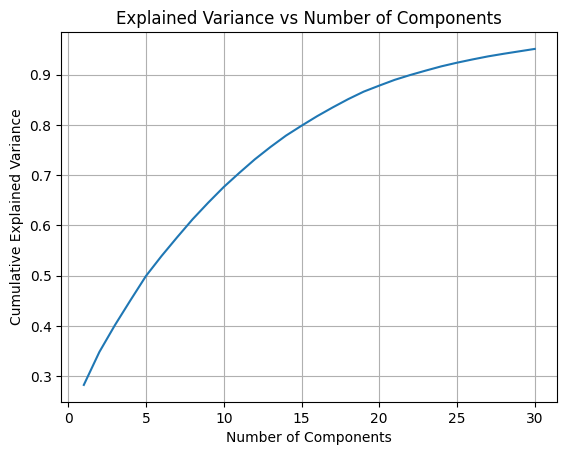

In [42]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance)
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs Number of Components")
plt.grid(True)
plt.show()


In [45]:
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components explaining 95% of variance: {n_components_95}")

Number of components explaining 95% of variance: 30


## Support Vector Classifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def tune_svm_hyperparameters(X_train, y_train):
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1],
        'degree': [3, 4, 5],
        'class_weight': [None, 'balanced']
    }

    svm = SVC()

    grid_search = GridSearchCV(
        estimator=svm,
        param_grid=param_grid,
        cv=5,
        n_jobs=-1,
        verbose=1,
        scoring='accuracy'
    )

    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_
    print(f"Best parameters: {best_params}")
    print(f"Best cross-validation score: {best_score:.4f}")
    best_model = grid_search.best_estimator_
    return best_model, best_params, best_score

best_model, best_params, best_score = tune_svm_hyperparameters(X_train_pca, y_train)


Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best parameters: {'C': 1, 'class_weight': None, 'degree': 5, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validation score: 0.7626


In [54]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', sc),
    ('pca', pca),
    ('svc', best_model)
])

In [56]:
from sklearn.metrics import confusion_matrix

y_pred_train = pipeline.predict(X_train)
print(confusion_matrix(y_true=y_train, y_pred=y_pred_train))

[[291   1]
 [  2 384]]


## Test Dataset

In [ ]:
def preprocess(data, audio_dir):
    X = []
    for _, row in data.iterrows():

        y, sr = librosa.load(audio_dir + "/" + row["Audio"], duration=2)

        target_length = sr * 2
        if len(y) < target_length:
            y = np.pad(y, (0, target_length - len(y)))
        elif len(y) > target_length:
            y = y[:target_length]

        chroma = librosa.feature.chroma_stft(y=y, sr=sr).flatten()
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13).flatten()
        spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr).flatten()
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr).flatten()

        X.append(np.concatenate([chroma, mfcc, spectral_centroid, spectral_contrast]))

    X1 = np.array(X)
    return X1
test_dataset = pd.read_csv(r"Test.csv")
test_dataset = test_dataset.rename(columns={'New' : 'Audio'})
X_test = preprocess(test_dataset, audio_dir)

In [65]:
feature_vector = extract_short_audio_features(audio_dir, test_dataset)
X_test = np.array(feature_vector)
X_test.shape

(181, 60)

In [66]:
y_pred_test = pipeline.predict(X_test)

In [ ]:
y_pred_final = pd.DataFrame(y_pred_test, columns=['Classification'])
y_pred_final['Classification'] = y_pred_final['Classification'].apply(lambda x: 'Major' if x == 1 else 'Minor')
y_pred_final.to_csv('Submission_2.csv', index=False)